In [56]:
%%capture
!pip install torchsummary
!pip install poutyne 
!pip install livelossplot 
!pip install albumentations
!pip install torchvision
!pip install efficientnet_pytorch
!pip install opencv-contrib-python
!pip install imutils
!sudo apt-get update 
!sudo apt-get install ffmpeg libsm6 libxext6  -y

In [112]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from torchsummary import summary 
import poutyne
from poutyne.framework import Model 
from poutyne.framework import ModelCheckpoint 
from poutyne.framework import EarlyStopping
from livelossplot import PlotLossesPoutyne # This module talks with Poutyne
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imutils import paths
import cv2
from sklearn.ensemble import IsolationForest
from torch.utils.data import Subset
from PIL import Image
import collections
from skimage import io

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 200

np.random.seed(2342)
torch.manual_seed(2342)
poutyne.set_seeds(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

The model will run on cuda


In [61]:
!rm -r traindata/.ipynb_checkpoints
mydataset = ImageFolder("traindata/")
idx = [Image.open(mydataset.imgs[i][0]).size for i in range(len(mydataset)) ]
df = pd.DataFrame.from_dict(collections.Counter(idx), orient='index').reset_index()
print(df)


rm: cannot remove 'traindata/.ipynb_checkpoints': No such file or directory
         index     0
0   (300, 300)  4141
1   (219, 230)     1
2   (299, 169)     1
3   (220, 229)     1
4   (261, 193)     1
5   (225, 225)    19
6   (201, 251)     3
7   (275, 183)     3
8   (181, 278)     1
9   (215, 234)     1
10  (181, 279)     1
11  (300, 168)     1
12  (284, 177)     1
13  (221, 228)     1
14  (262, 193)     1
15  (301, 167)     1
16  (183, 276)     1
17  (238, 211)     1
18  (366, 138)     1
19  (310, 163)     1
20  (277, 182)     1
21  (214, 236)     1
22  (182, 277)     1
23  (253, 199)     1
24  (870, 900)     1
25  (800, 957)     1
26  (301, 168)     1
27  (256, 197)     1
28  (259, 194)     1
29  (254, 199)     1
30  (178, 283)     1
31  (202, 250)     1
32  (217, 232)     1


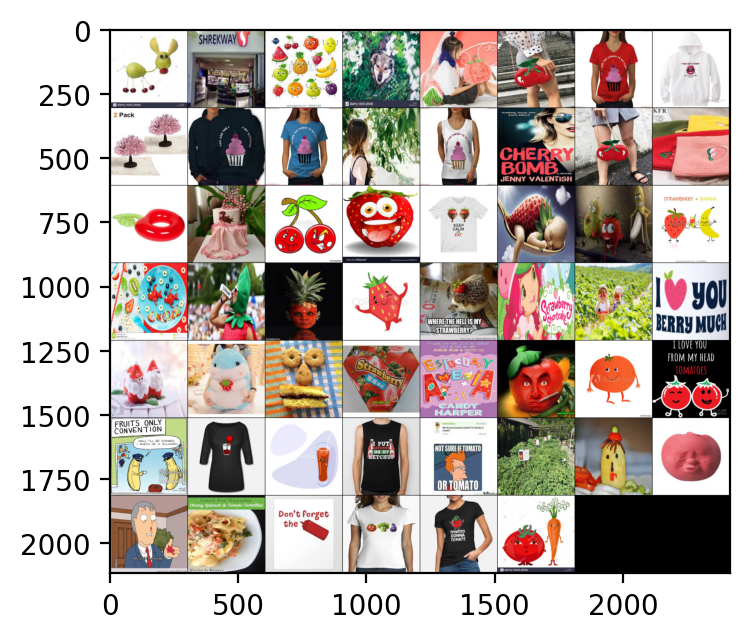

In [102]:
mydataset = ImageFolder("traindata/")
badidx = [i for i in range(len(mydataset)) if Image.open(mydataset.imgs[i][0]).size != (300, 300) ]
mydataset = ImageFolder("traindata/",transform=transforms.Compose([transforms.Resize(size=[300,300]),transforms.ToTensor()]))
badsubset = Subset(mydataset, badidx)

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

dataiter = iter(DataLoader(badsubset,batch_size=64))
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

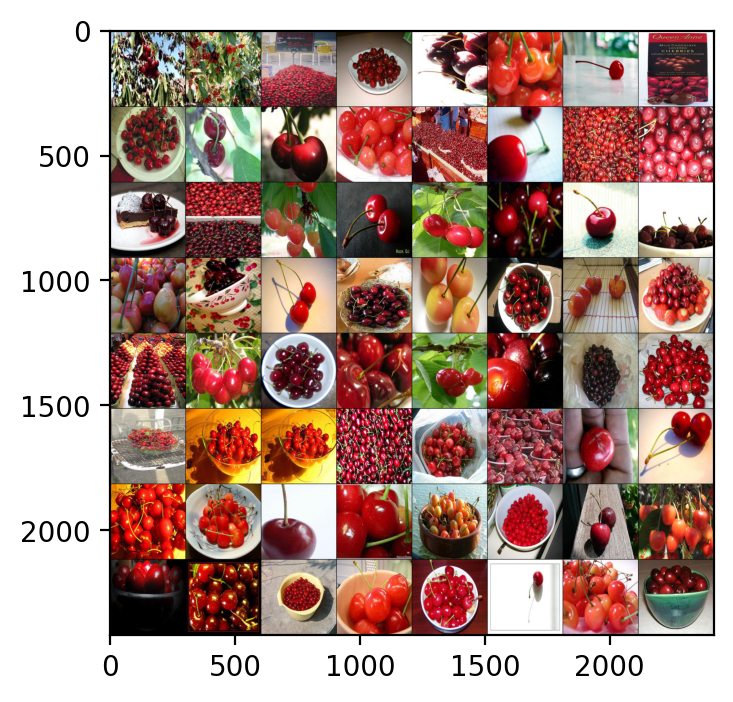

In [103]:
goodidx = [i for i in range(len(mydataset)) if Image.open(mydataset.imgs[i][0]).size == (300, 300) ]
mydataset = ImageFolder("traindata/",transform=transforms.ToTensor())
goodsubset = Subset(mydataset, goodidx)

dataiter = iter(DataLoader(goodsubset,batch_size=64))
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [3]:
class WrapperDataset:
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [4]:
mymean=[0.485, 0.456, 0.406]
mystd=[0.229, 0.224, 0.225]

traintransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mymean,std=mystd)])
rtraintransform = transforms.Compose([transforms.RandomResizedCrop(size=300, scale=(0.8, 1.0)), transforms.RandomRotation(degrees=15), 
                                    transforms.CenterCrop(size=300), transforms.ToTensor(), transforms.Normalize(mean=mymean,std=mystd)])

vftraintransform = copy.deepcopy(traintransform)
vftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))
hftraintransform = copy.deepcopy(traintransform)
hftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
vhftraintransform = copy.deepcopy(traintransform)
vhftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
vhftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))
rvftraintransform = copy.deepcopy(rtraintransform)
rvftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))
rhftraintransform = copy.deepcopy(rtraintransform)
rhftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
rvhftraintransform = copy.deepcopy(rtraintransform)
rvhftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
rvhftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))

excltransform =  transforms.Compose([transforms.Resize(size=[300,300]), transforms.ToTensor(), transforms.Normalize(mean=mymean,std=mystd)])

testtransform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mymean,std=mystd)])

In [105]:
batch_size = 8
num_workers = 0

trainset = Subset(ImageFolder('traindata/',transform=traintransform), goodidx)
vftrainset = Subset(ImageFolder('traindata/', transform=vftraintransform), goodidx)
hftrainset = Subset(ImageFolder('traindata/', transform=hftraintransform), goodidx)
vfhftrainset = Subset(ImageFolder('traindata/', transform=vhftraintransform), goodidx)
rtrainset = Subset(ImageFolder('traindata/',transform=traintransform), goodidx)
rvftrainset = Subset(ImageFolder('traindata/', transform=rvftraintransform), goodidx)
rhftrainset = Subset(ImageFolder('traindata/', transform=rhftraintransform), goodidx)
rvfhftrainset = Subset(ImageFolder('traindata/', transform=rvhftraintransform), goodidx)
increased_dataset = torch.utils.data.ConcatDataset([trainset,vftrainset,hftrainset,vfhftrainset,rtrainset,rvftrainset,rhftrainset,rvfhftrainset])

#increased_dataset = torch.utils.data.ConcatDataset([trainset])

num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_size = 0.2 
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

new_list1 = [x+num_train for x in train_idx]
new_list2= [x+2*num_train for x in train_idx]
new_list3 = [x+3*num_train for x in train_idx]
new_list4 = [x+4*num_train for x in train_idx]
new_list5 = [x+5*num_train for x in train_idx]
new_list6 = [x+6*num_train for x in train_idx]
new_list7 = [x+7*num_train for x in train_idx]

train_idx= train_idx+new_list1+new_list2+new_list3+new_list4+new_list5+new_list6+new_list7

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

testset = ImageFolder('traindata/', transform=testtransform)

trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=batch_size, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=batch_size, shuffle=False,pin_memory=True)
testloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=batch_size, shuffle=False,pin_memory=True)
#testloader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers,pin_memory=True,shuffle=True)
classes = ('cherry', 'strawberry', 'tomato')

len(train_idx) ==>  26504
len(valid_idx) ==>  828


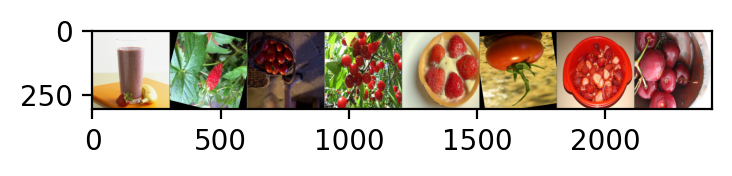

strawberry strawberry tomato cherry strawberry tomato strawberry cherry


In [110]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = mystd * img + mymean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


<BarContainer object of 10 artists>

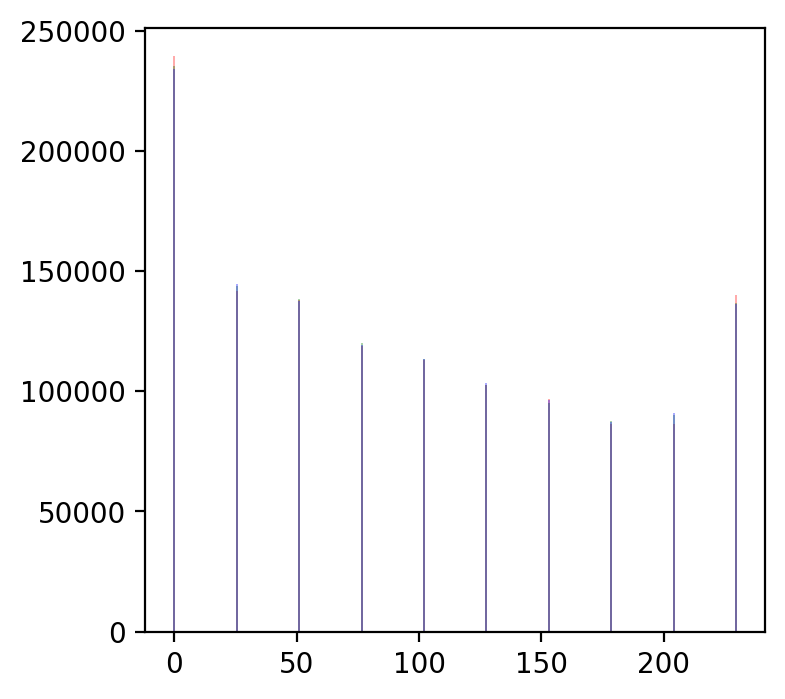

In [117]:
nb_bins = 10
count_r = np.zeros(nb_bins)
count_g = np.zeros(nb_bins)
count_b = np.zeros(nb_bins)

root = './'
for image in os.listdir('traindata/tomato'):  
  if image.endswith('.jpg'):
    x = io.imread('traindata/tomato/'+image)
    hist_r = np.histogram(x[0], bins=nb_bins, range=[0, 255])
    hist_g = np.histogram(x[1], bins=nb_bins, range=[0, 255])
    hist_b = np.histogram(x[2], bins=nb_bins, range=[0, 255])
    count_r += hist_r[0]
    count_g += hist_g[0]
    count_b += hist_b[0]

bins = hist_r[1]
fig = plt.figure()
plt.bar(bins[:-1], count_r, color='r', alpha=0.33)
plt.bar(bins[:-1], count_g, color='g', alpha=0.33)
plt.bar(bins[:-1], count_b, color='b', alpha=0.33)



In [119]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 72 * 72, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net().to(device)

summary(model=net, input_size=(3, 300, 300), batch_size=batch_size) # Summarize
#!nvidia-smi # Use this command to figure out the GPU assigned by Google  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 6, 296, 296]             456
         MaxPool2d-2           [8, 6, 148, 148]               0
            Conv2d-3          [8, 16, 144, 144]           2,416
         MaxPool2d-4            [8, 16, 72, 72]               0
           Dropout-5            [8, 16, 72, 72]               0
            Linear-6                   [8, 120]       9,953,400
            Linear-7                    [8, 84]          10,164
           Dropout-8                    [8, 84]               0
            Linear-9                     [8, 3]             255
Total params: 9,966,691
Trainable params: 9,966,691
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.24
Forward/backward pass size (MB): 70.50
Params size (MB): 38.02
Estimated Total Size (MB): 116.76
-----------------------------------

In [21]:
def better_poutyne_train(model_name, pytorch_model):
    plotlosses = PlotLossesPoutyne()

    callbacks = [
        # Save the latest weights 
        ModelCheckpoint(model_name + '_last_epoch.ckpt', \
                        temporary_filename='last_epoch.ckpt.tmp'),
        # EarlyStopping
        EarlyStopping(monitor='val_acc', patience=0, verbose=True, mode='max'),

        plotlosses

    ]
    
    # Select the optimizer and the loss function 
    optimizer = optim.Adam(pytorch_model.parameters(), lr=0.0001)
    #optimizer = optim.SGD(pytorch_model.parameters(), lr=0.001, momentum=0.9)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train
    model.fit_generator(trainloader, valloader, epochs=epochs, callbacks=callbacks)
    # Test
    test_loss, test_acc, pred_y, true_y = model.evaluate_generator(testloader,return_pred=True,return_ground_truth=True)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    cm=confusion_matrix(true_y, pred_y.argmax(axis=1))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    disp.plot()
    plt.show()

    return None 



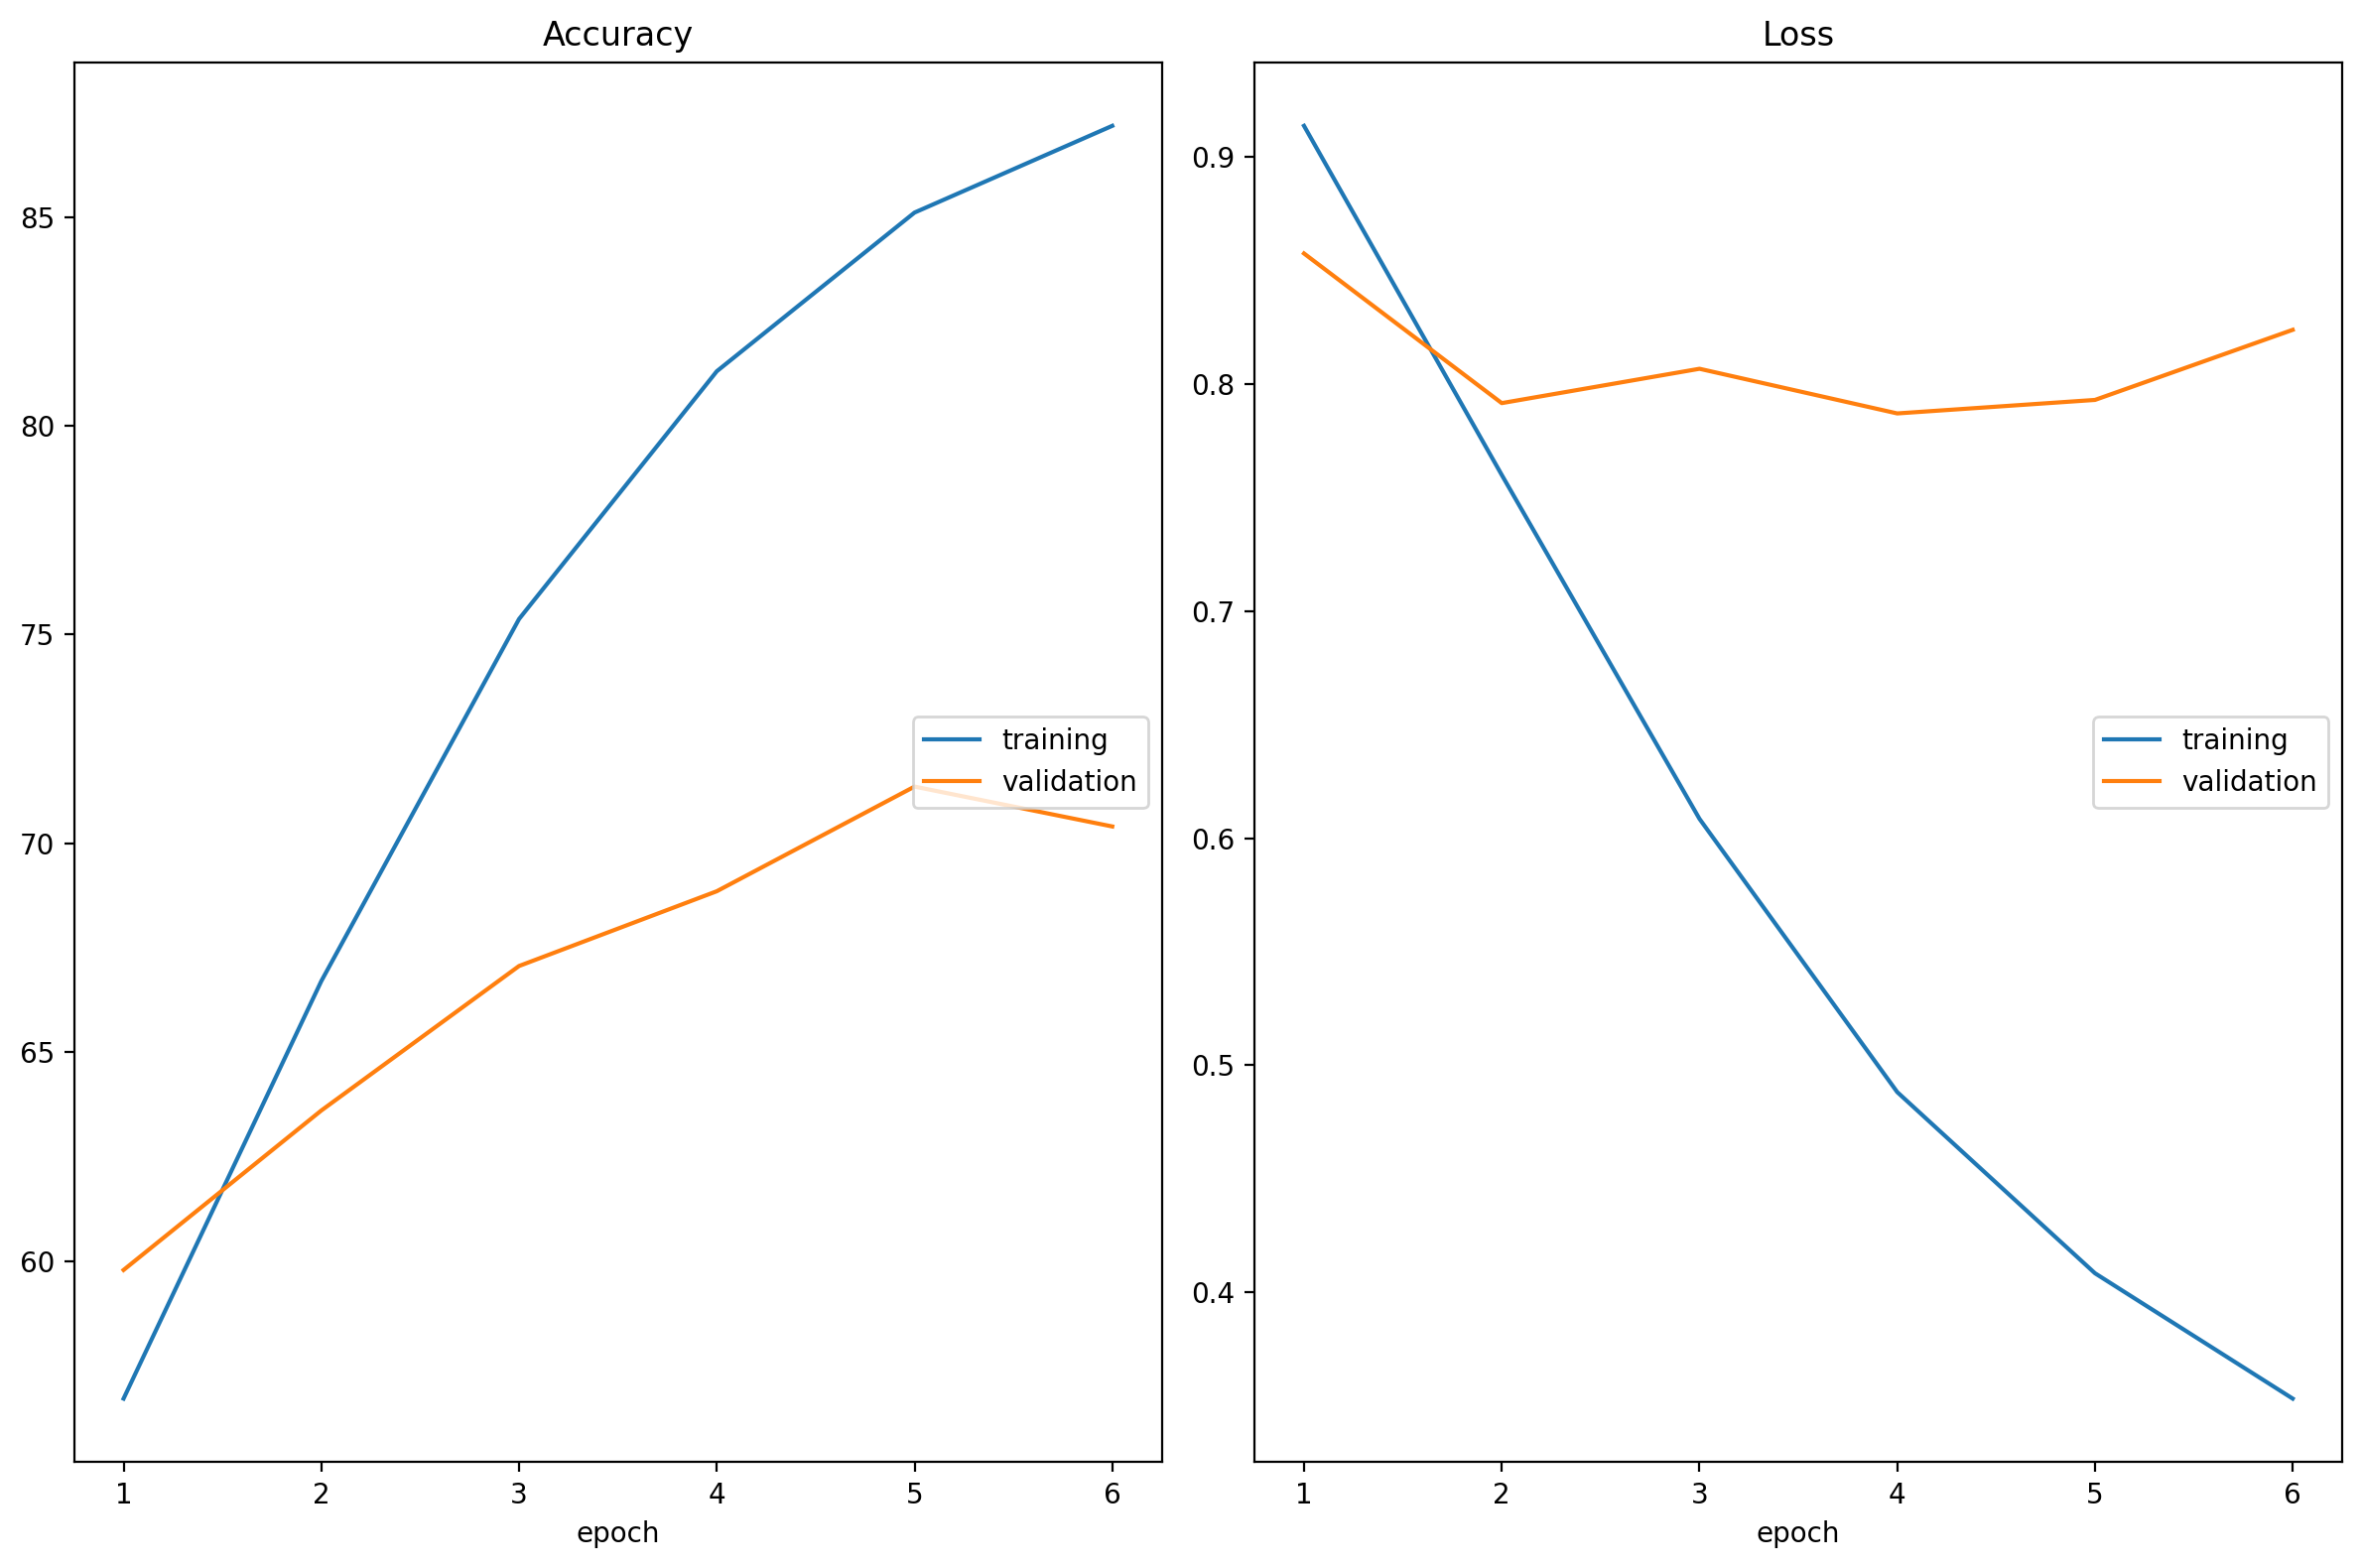

Accuracy
	training         	 (min:   56.705, max:   87.183, cur:   87.183)
	validation       	 (min:   59.785, max:   71.360, cur:   70.406)
Loss
	training         	 (min:    0.353, max:    0.914, cur:    0.353)
	validation       	 (min:    0.787, max:    0.857, cur:    0.824)
Test steps: 524 12.23s test_loss: 0.214434 test_acc: 93.699284                                                  
Test:
	Loss:  0.214
	Accuracy:  93.699


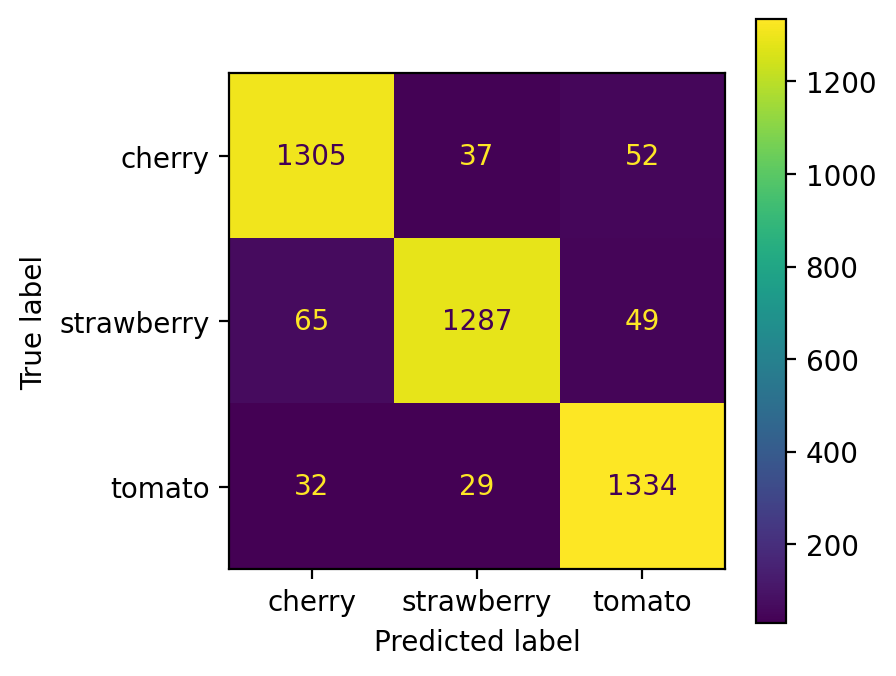

In [22]:
epochs=10
better_poutyne_train("trial1",net)

In [10]:
PATH = './myown.pth'
torch.save(net.state_dict(), PATH)

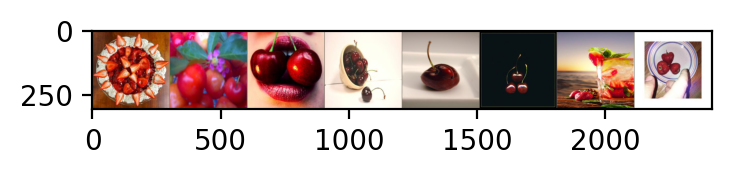

GroundTruth:  strawberry cherry cherry cherry cherry cherry strawberry strawberry


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [12]:
#net = Net().to(device)
#net.load_state_dict(torch.load(PATH))

In [13]:
from torchvision import models
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), #nn.Dropout(0.2),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))

        model = model.to(device)

    return model



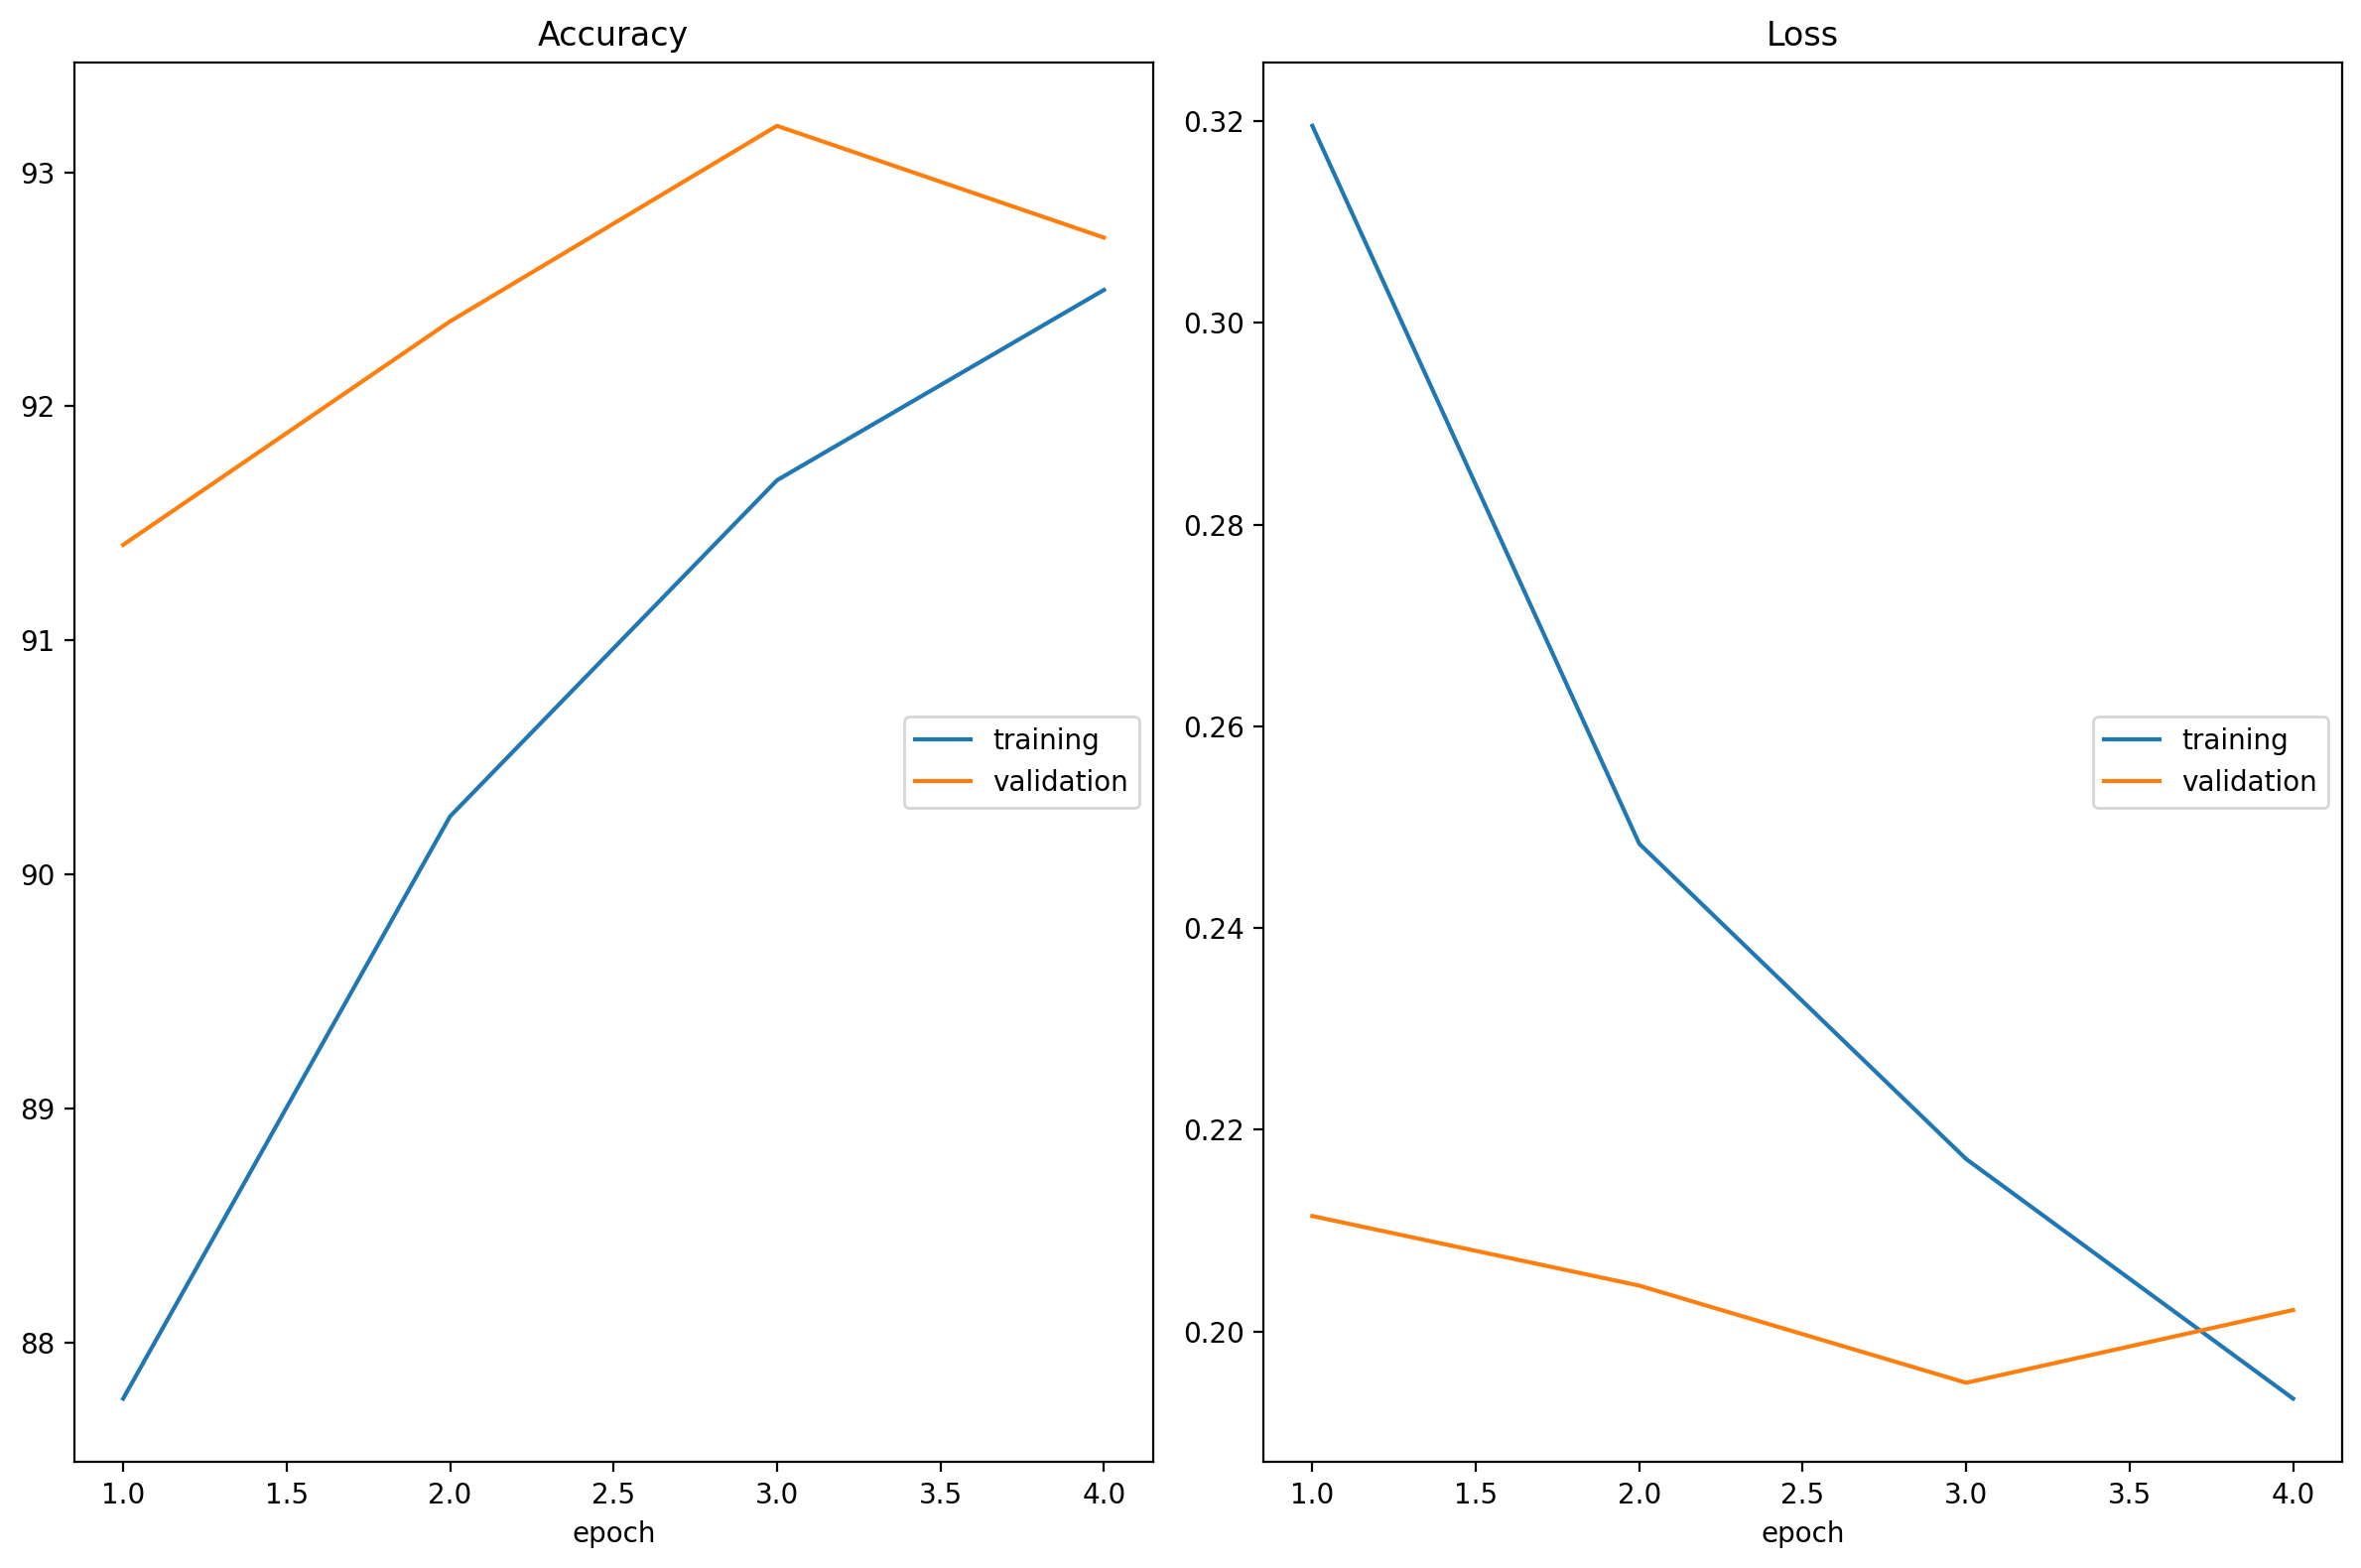

Accuracy
	training         	 (min:   87.761, max:   92.497, cur:   92.497)
	validation       	 (min:   91.408, max:   93.198, cur:   92.721)
Loss
	training         	 (min:    0.193, max:    0.320, cur:    0.193)
	validation       	 (min:    0.195, max:    0.211, cur:    0.202)
Test steps: 524 1m1.99s test_loss: 0.100463 test_acc: 96.897375                                                  
Test:
	Loss:  0.100
	Accuracy:  96.897


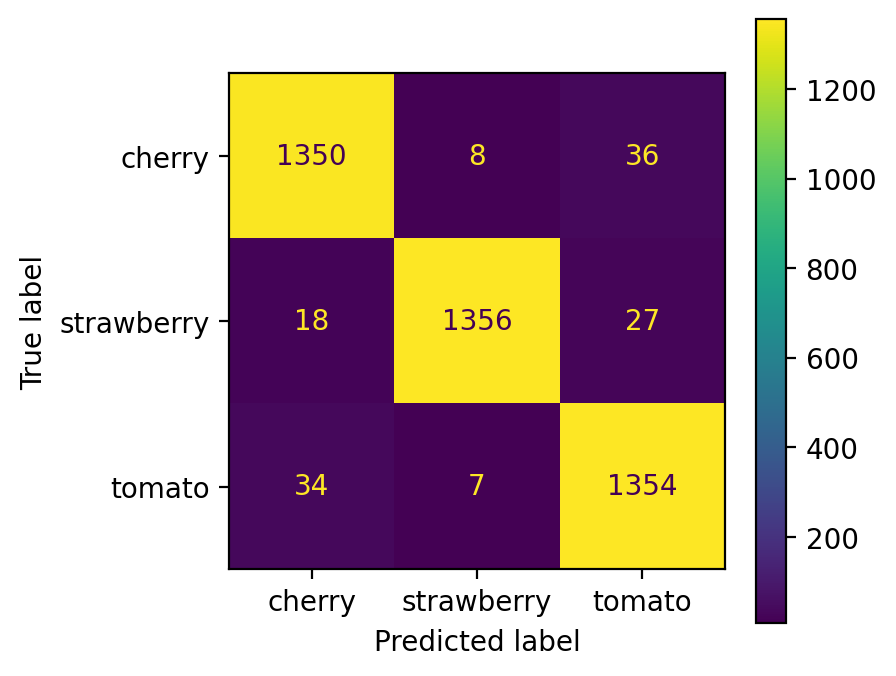

In [14]:
vgg16model = get_pretrained_model('vgg16')
better_poutyne_train("trial2",vgg16model)

In [15]:
PATH = './vgg16model.pth'
torch.save(vgg16model.state_dict(), PATH)

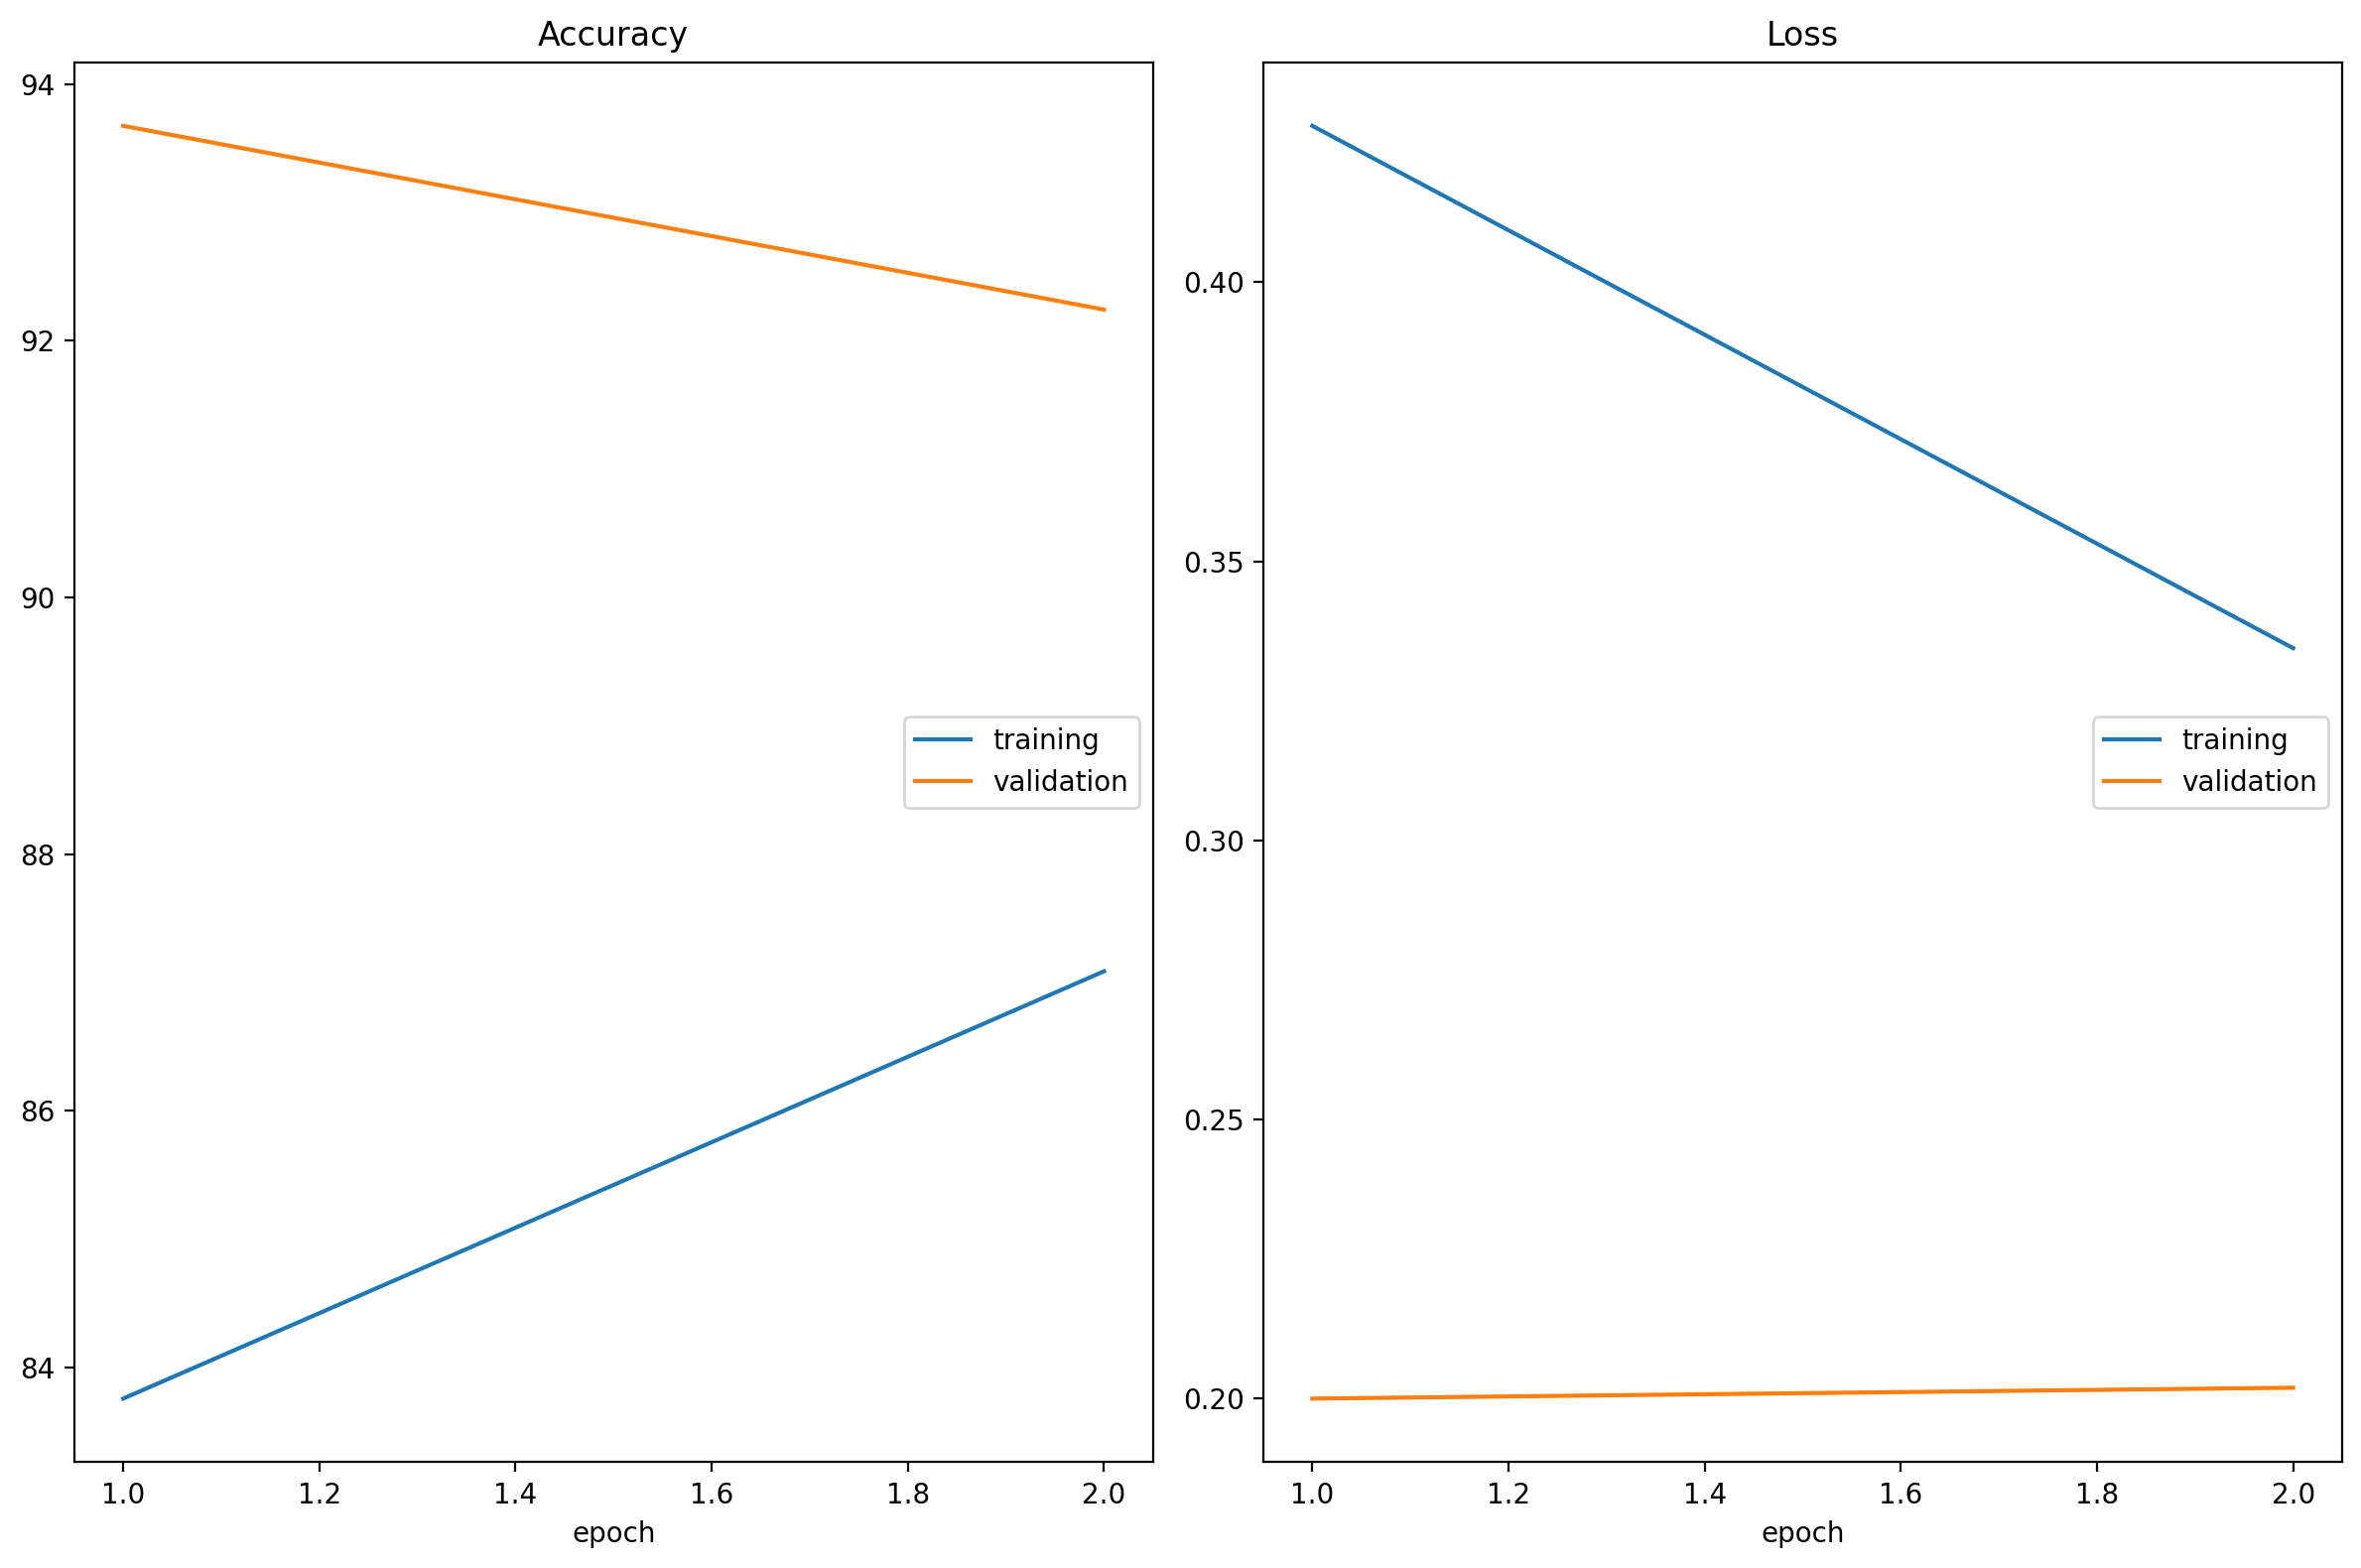

Accuracy
	training         	 (min:   83.756, max:   87.086, cur:   87.086)
	validation       	 (min:   92.243, max:   93.675, cur:   92.243)
Loss
	training         	 (min:    0.334, max:    0.428, cur:    0.334)
	validation       	 (min:    0.200, max:    0.202, cur:    0.202)
Test steps: 524 34.19s test_loss: 0.166106 test_acc: 93.818616                                                  
Test:
	Loss:  0.166
	Accuracy:  93.819


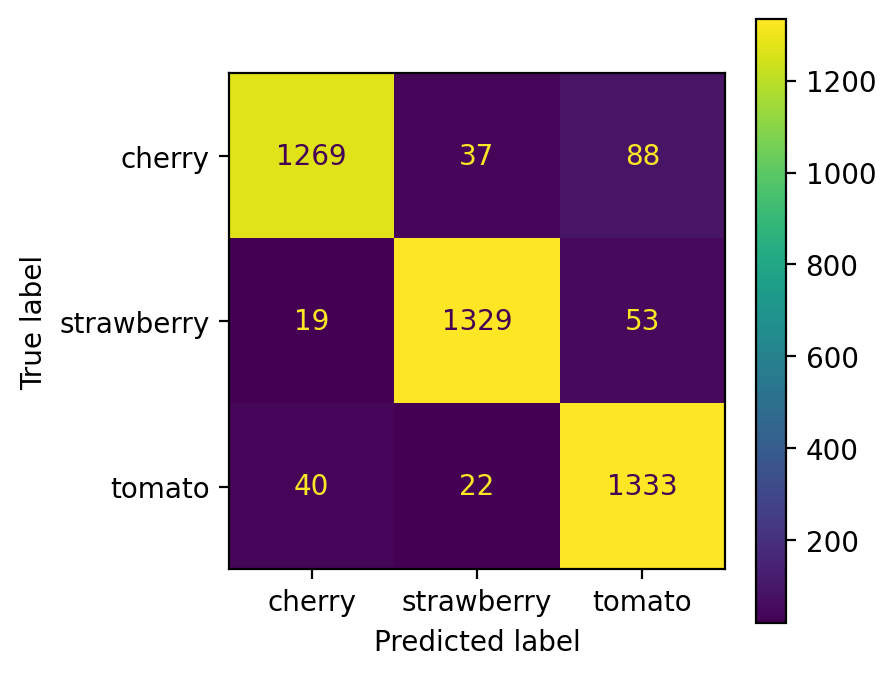

In [16]:

resnet50model = get_pretrained_model('resnet50')
better_poutyne_train("trial3",resnet50model)

In [17]:
PATH = './resnet50model.pth'
torch.save(resnet50model.state_dict(), PATH)

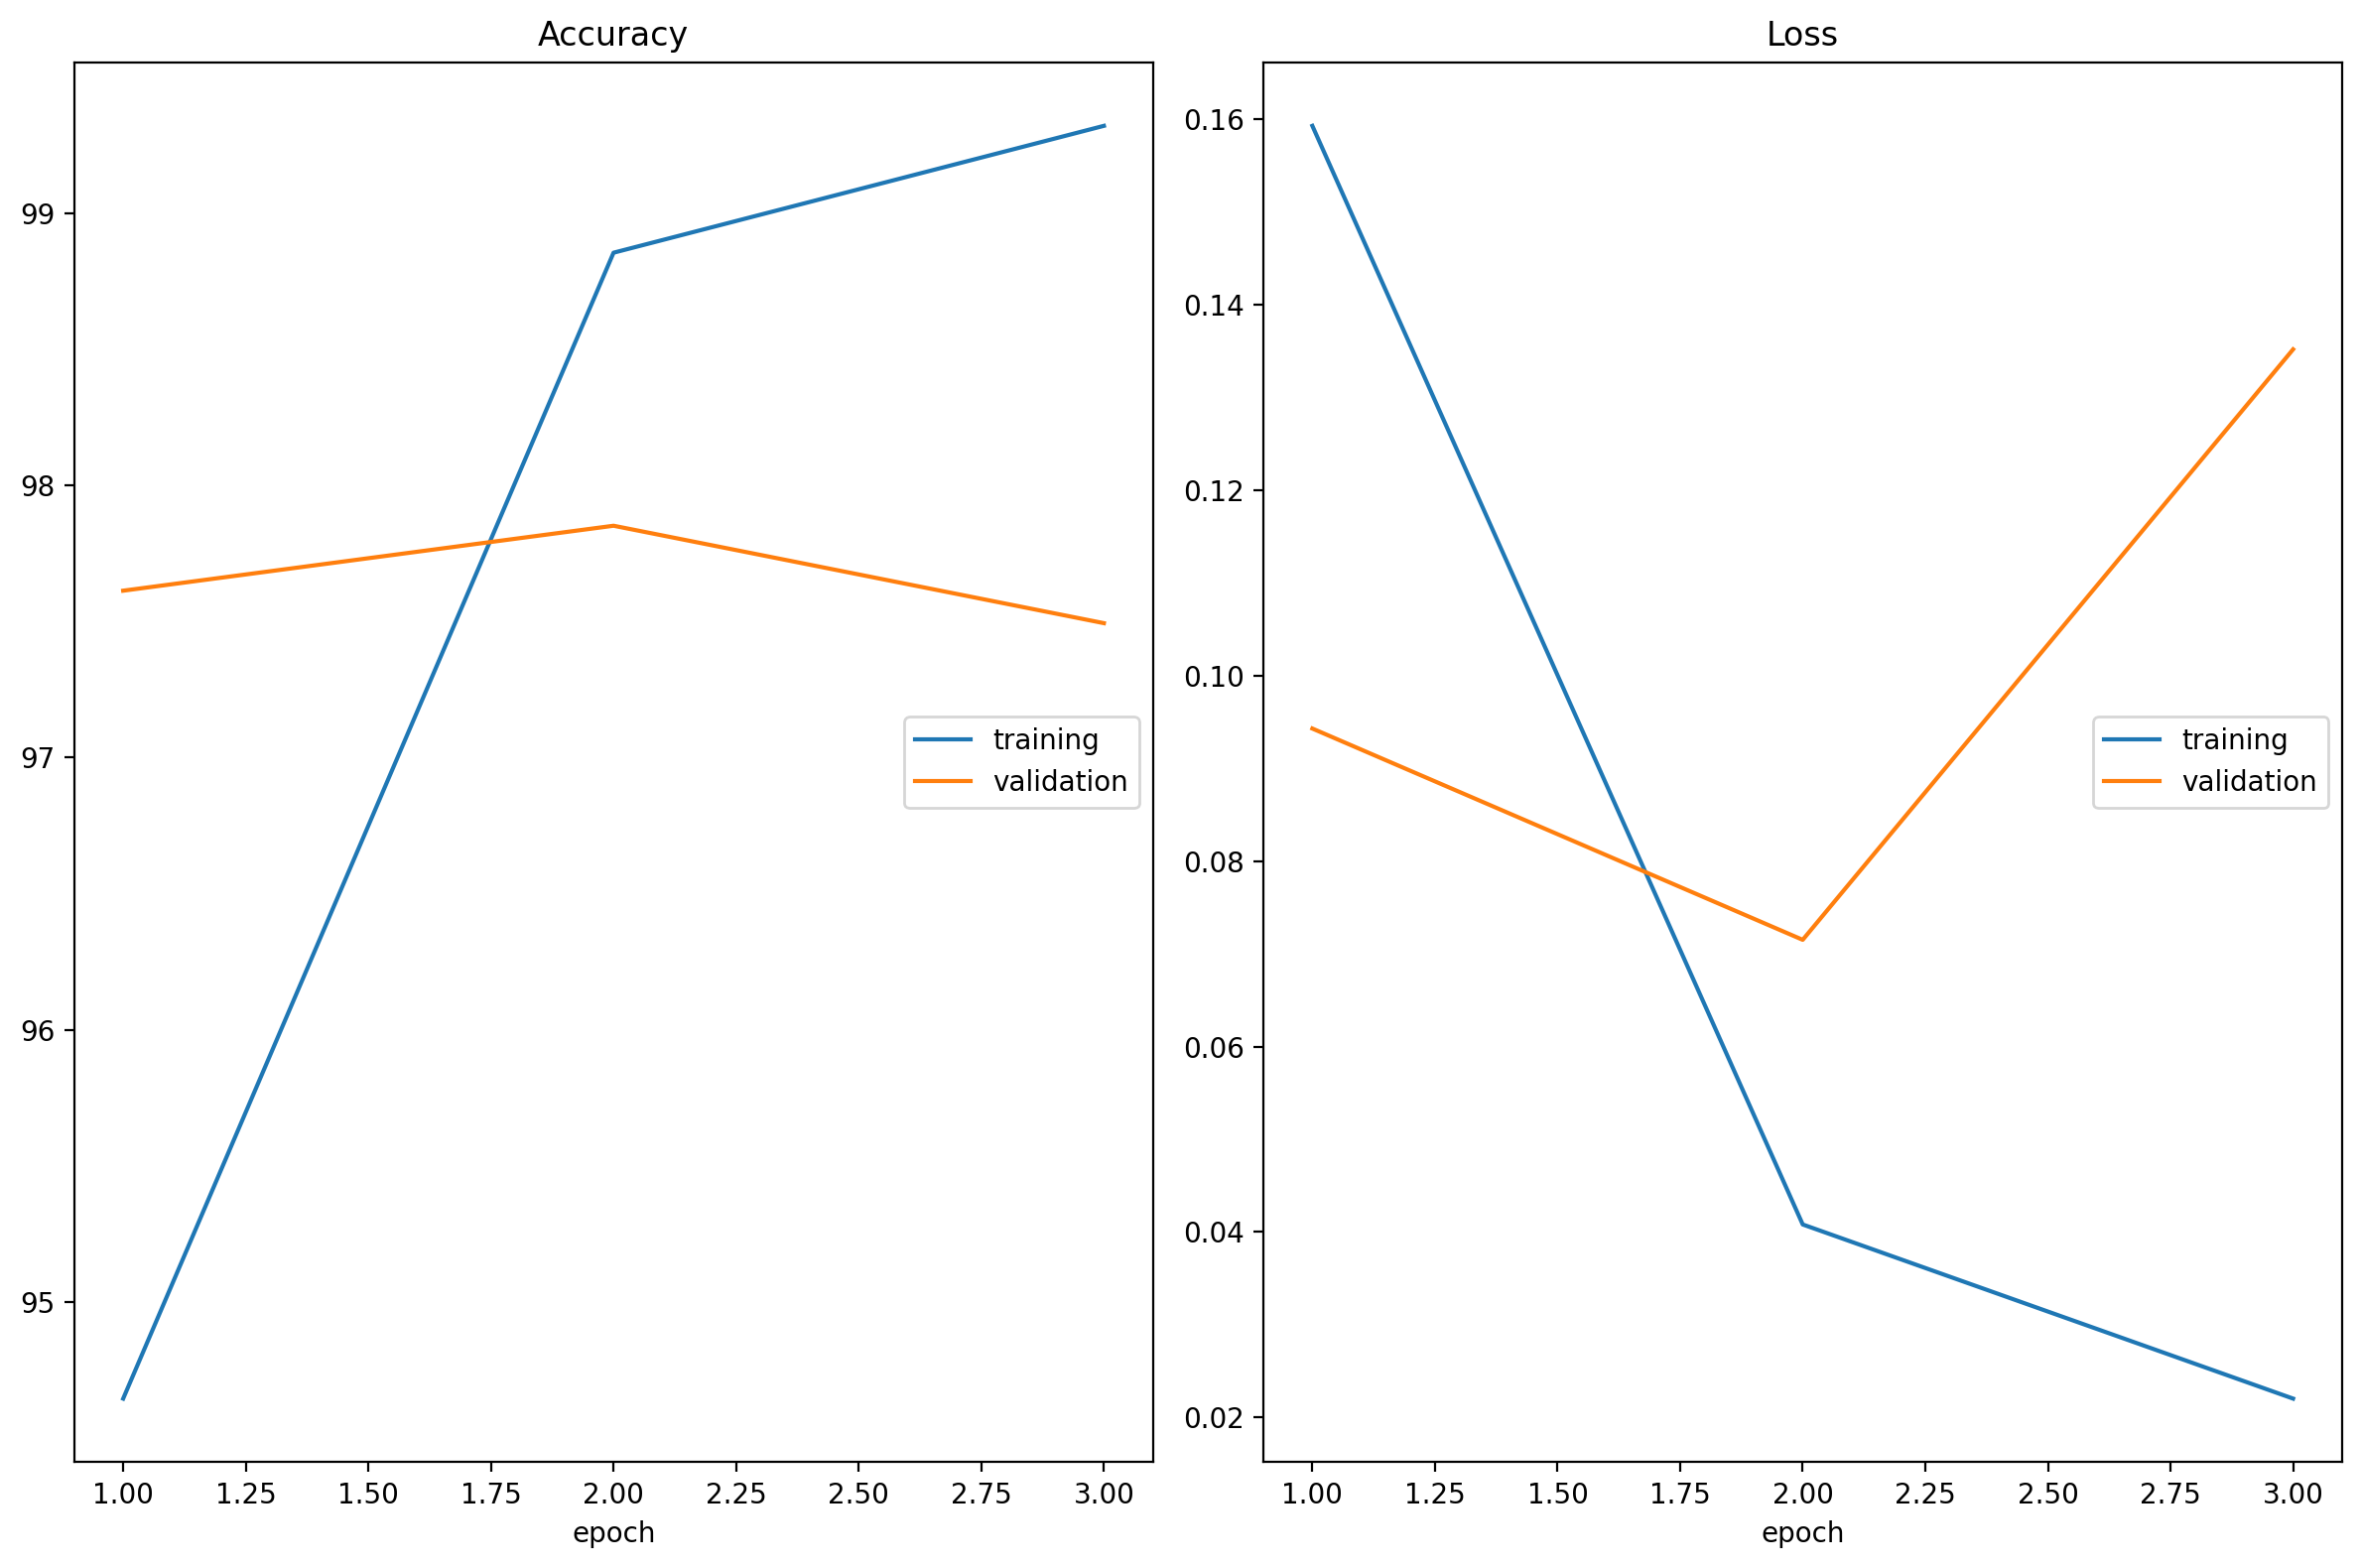

Accuracy
	training         	 (min:   94.645, max:   99.321, cur:   99.321)
	validation       	 (min:   97.494, max:   97.852, cur:   97.494)
Loss
	training         	 (min:    0.022, max:    0.159, cur:    0.022)
	validation       	 (min:    0.072, max:    0.135, cur:    0.135)
Test steps: 524 31.82s test_loss: 0.027410 test_acc: 99.498807                                                  
Test:
	Loss:  0.027
	Accuracy:  99.499


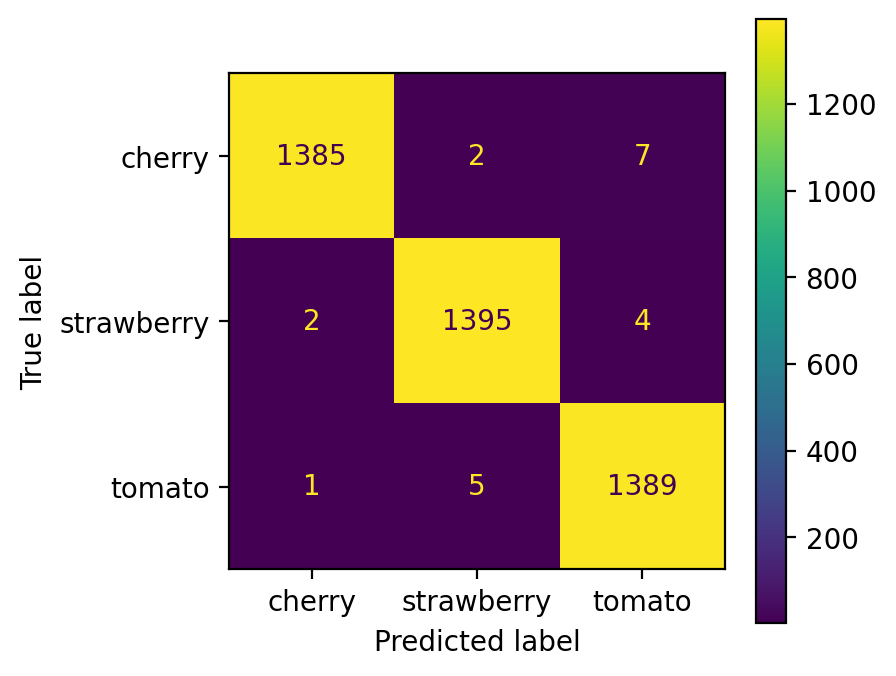

In [18]:
efficientnet = EfficientNet.from_pretrained('efficientnet-b3', num_classes=3)
better_poutyne_train("trial4",efficientnet)

In [19]:
PATH = './efficientnet.pth'
torch.save(efficientnet.state_dict(), PATH)